In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import osmnx as ox
from shapely import wkt

# RAIL

### Import merged  file, reconciled NUMBAT + STATION LOCATIONS

In [8]:
# Load the data
df = pd.read_csv(os.path.join('data','raw','tfl','numbat_sat_exit.csv'))
df.head()

,NLC,ASC,Station,Morning,Midday,Evening,Late,Total
0,750,ABRd,Abbey Road,228,861,397,24,1510
1,1404,ACCr,Acton Central,170,1327,476,26,1999
2,3000,AMLr,Acton Main Line,188,699,516,14,1417
3,500,ACTu,Acton Town,926,4195,2101,352,7574
4,9441,ADVt,Addington Village,0,0,0,0,0


In [19]:
# Load the shapefile
gdf = pd.read_csv(os.path.join('data','raw','tfl','numbat_geometry.csv'))
gdf['geometry'] = gdf['geometry'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(gdf, geometry='geometry', crs='epsg:4326')
gdf.to_crs(epsg=27700, inplace=True) # convert to British National Grid
gdf.head()

,nlc,asc,stationname,geometry
0,750,ABRd,Abbey Road,POINT (539079.469 183399.270)
1,5131,ABWr,Abbey Wood,POINT (547362.001 179062.289)
2,1404,ACCr,Acton Central,POINT (520636.152 180255.972)
3,3000,AMLr,Acton Main Line,POINT (520282.791 181216.105)
4,500,ACTu,Acton Town,POINT (519466.665 179629.597)


In [20]:
# Merge the data into the shapefile
gdf = gdf.merge(df, left_on='nlc', right_on='NLC', how='left')
gdf = gdf.drop(columns=['NLC','ASC','asc','Station'])
gdf.head()

,nlc,stationname,geometry,Morning,Midday,Evening,Late,Total
0,750,Abbey Road,POINT (539079.469 183399.270),228,861,397,24,1510
1,5131,Abbey Wood,POINT (547362.001 179062.289),1572,9565,4858,265,16260
2,1404,Acton Central,POINT (520636.152 180255.972),170,1327,476,26,1999
3,3000,Acton Main Line,POINT (520282.791 181216.105),188,699,516,14,1417
4,500,Acton Town,POINT (519466.665 179629.597),926,4195,2101,352,7574


In [21]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 432 entries, 0 to 431
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   nlc          432 non-null    int64   
 1   stationname  432 non-null    object  
 2   geometry     432 non-null    geometry
 3   Morning      432 non-null    int64   
 4   Midday       432 non-null    int64   
 5   Evening      432 non-null    int64   
 6   Late         432 non-null    int64   
 7   Total        432 non-null    int64   
dtypes: geometry(1), int64(6), object(1)
memory usage: 27.1+ KB


In [23]:
# download the Greater London boundary
greater_london = ox.geocode_to_gdf('Greater London, UK')
greater_london.to_crs(epsg=27700, inplace=True)

# subset points that are within the boundary of london
gdf = gdf[gdf.geometry.intersects(greater_london.geometry[0])]
gdf.reset_index(drop=True,inplace=True)

gdf.info()
#400 stations are within the Greater London boundary'

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   nlc          400 non-null    int64   
 1   stationname  400 non-null    object  
 2   geometry     400 non-null    geometry
 3   Morning      400 non-null    int64   
 4   Midday       400 non-null    int64   
 5   Evening      400 non-null    int64   
 6   Late         400 non-null    int64   
 7   Total        400 non-null    int64   
dtypes: geometry(1), int64(6), object(1)
memory usage: 25.1+ KB


Text(0.5, 1.0, 'Total Exit flow - TfL Rail')

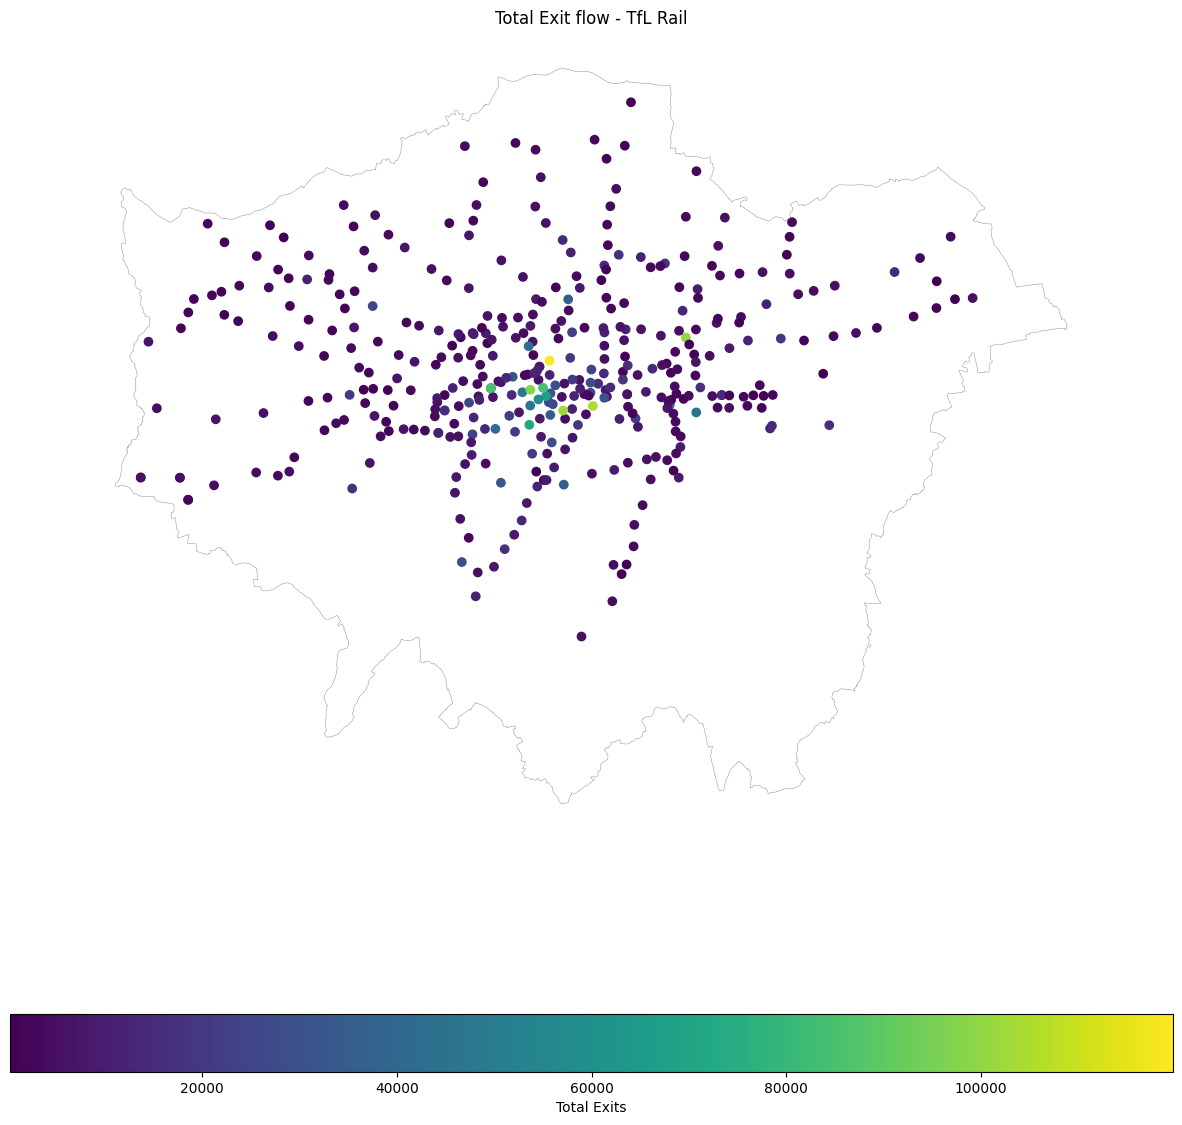

In [24]:
# plot stations_numbat_geo based on Total

fig,ax = plt.subplots(1,1,figsize=(15,15))
gdf.plot(column='Total',ax=ax,legend=True,legend_kwds={'label': "Total Exits",'orientation': "horizontal"})
greater_london.boundary.plot(ax=ax, color='grey', linewidth=0.3)
ax.set_axis_off()
plt.title('Total Exit flow - TfL Rail')

In [26]:
gdf.head()

,nlc,stationname,geometry,Morning,Midday,Evening,Late,Total
0,750,Abbey Road,POINT (539079.469 183399.270),228,861,397,24,1510
1,5131,Abbey Wood,POINT (547362.001 179062.289),1572,9565,4858,265,16260
2,1404,Acton Central,POINT (520636.152 180255.972),170,1327,476,26,1999
3,3000,Acton Main Line,POINT (520282.791 181216.105),188,699,516,14,1417
4,500,Acton Town,POINT (519466.665 179629.597),926,4195,2101,352,7574


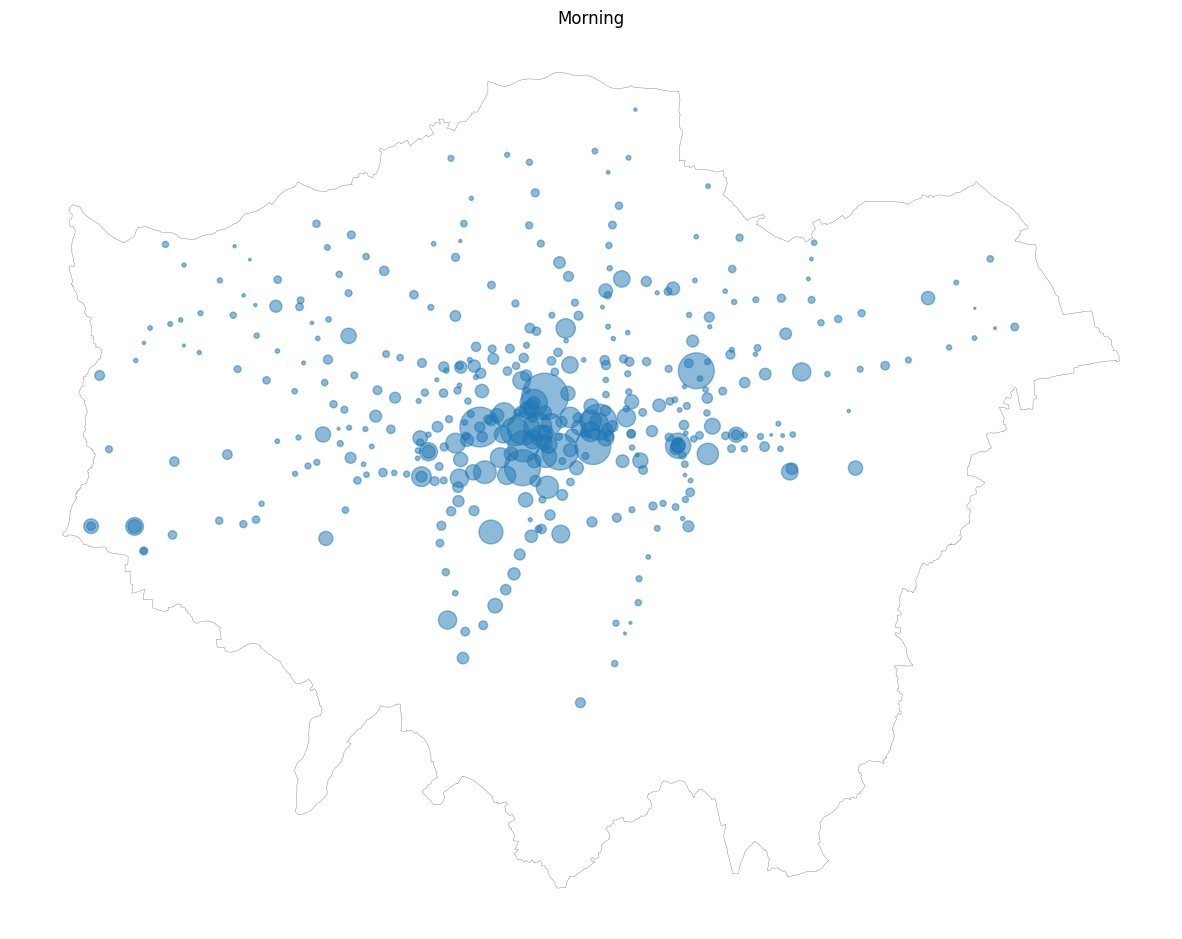

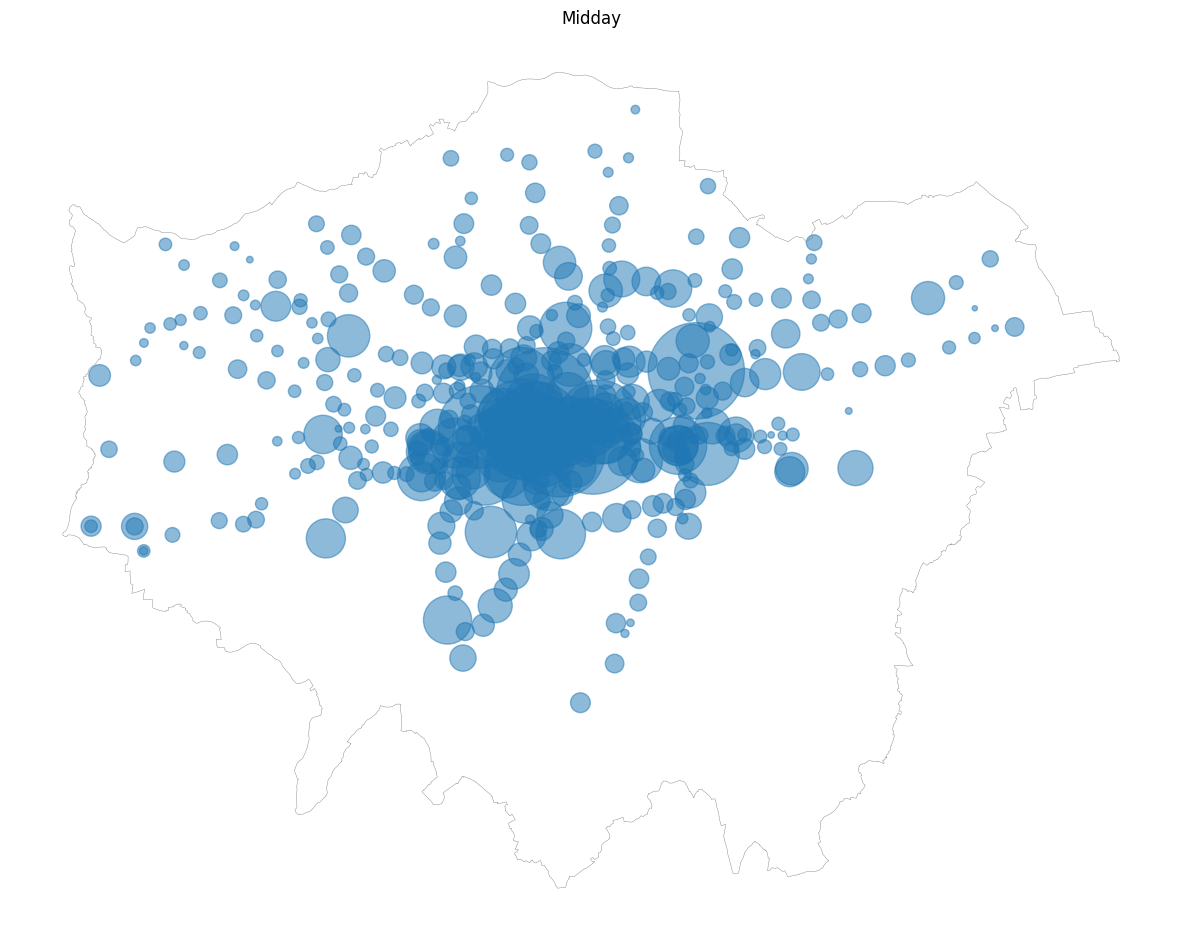

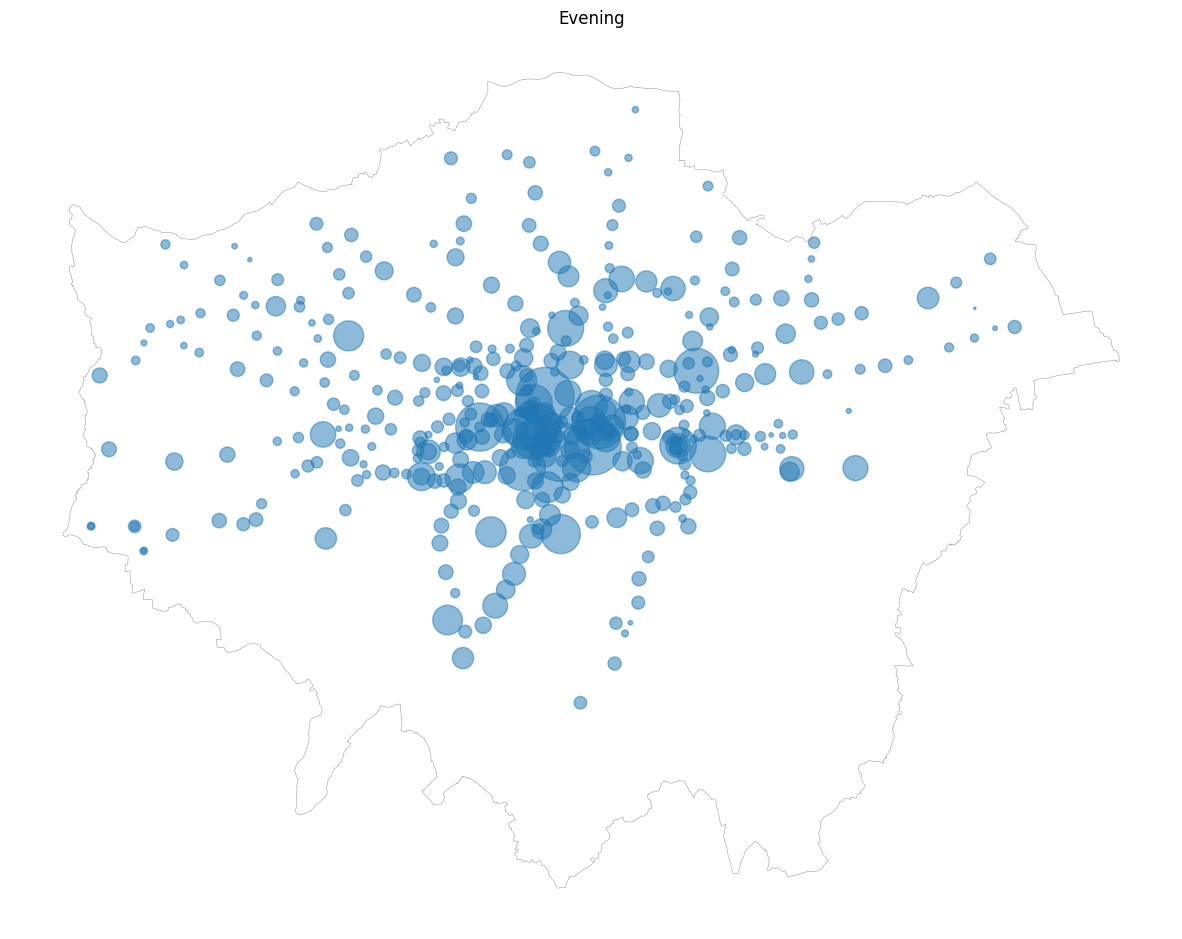

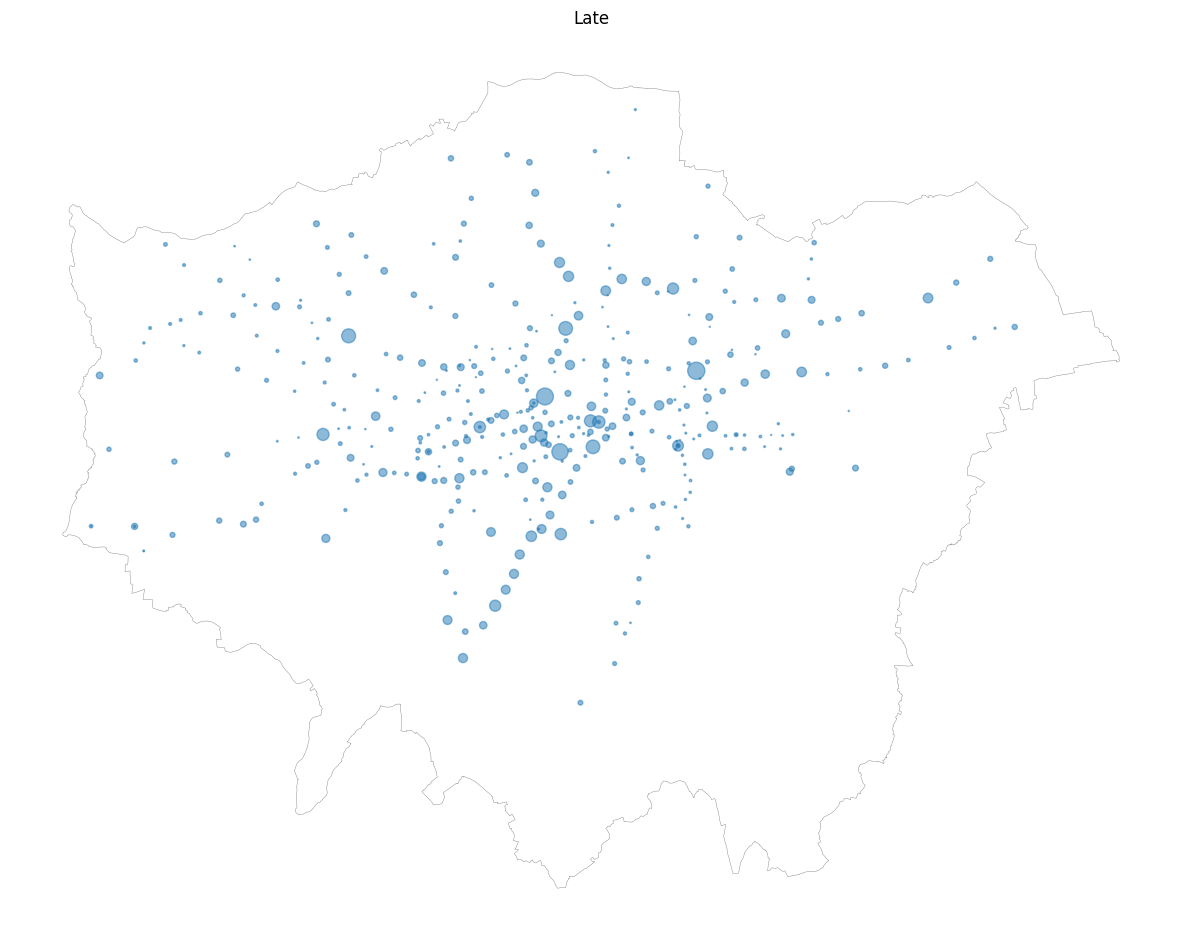

In [31]:
vmin = gdf['Midday'].min()
vmax = gdf['Midday'].max()
# make gif
images = []

for col in gdf.columns[3:7]: # 4 time bands
    fig,ax = plt.subplots(1,1,figsize=(15,15),sharex=True,sharey=True)
    markersize = gdf[col].values/15
    gdf.plot(markersize=markersize,ax=ax,legend=True,vmin=vmin,vmax=vmax,alpha=0.5) 
    greater_london.boundary.plot(ax=ax, color='grey', linewidth=0.3)
    ax.set_axis_off()
    plt.title(col)

    # save the plot and append to images list for gif
    plt.savefig(os.path.join('output','numbat_satexit_{}.png'.format(col)))
    images.append(imageio.imread(os.path.join('output','numbat_satexit_{}.png'.format(col))))

# make gif
imageio.mimsave('output/numbat.gif', images, loop=0, duration=500)


In [32]:
# Export stations_numbat_geo TO GEOJSON ESPG:27700
gdf.to_file('data/cleaned/flow_rail.gpkg', driver='GPKG')